<a href="https://www.kaggle.com/code/vanpatangan/predict-insurance-premiums-in-r?scriptVersionId=214851451" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries and data

In [1]:
# Import Libraries
suppressPackageStartupMessages({

library(tidyverse)  # Collection of packages including dplyr, ggplot2
library(snakecase)  # Converts strings to snake_case format
library(lubridate)  # Simplifies date and time handling
library(naniar)     # Tools for exploring and handling missing data
library(janitor)    # Data cleaning and examination functions
library(caret)      # Machine learning training and evaluation
library(lightgbm)   # Gradient boosting

})

In [2]:
# Import data 
train <- read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test <- read_csv("/kaggle/input/playground-series-s4e12/test.csv")

Rows: 1200000 Columns: 21


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Gender, Marital Status, Education Level, Occupation, Location, Po...
dbl  (10): id, Age, Annual Income, Number of Dependents, Health Score, Previ...
dttm  (1): Policy Start Date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 800000 Columns: 20


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Gender, Marital Status, Education Level, Occupation, Location, Po...
dbl   (9): id, Age, Annual Income, Number of Dependents, Health Score, Previ...
dttm  (1): Policy Start Date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Explore and clean data

In [3]:
# Inspect train set
summary(train)

# Print the first few rows 
head(train)

       id               Age           Gender          Annual Income   
 Min.   :      0   Min.   :18.00   Length:1200000     Min.   :     1  
 1st Qu.: 300000   1st Qu.:30.00   Class :character   1st Qu.:  8001  
 Median : 600000   Median :41.00   Mode  :character   Median : 23911  
 Mean   : 600000   Mean   :41.15                      Mean   : 32745  
 3rd Qu.: 899999   3rd Qu.:53.00                      3rd Qu.: 44634  
 Max.   :1199999   Max.   :64.00                      Max.   :149997  
                   NA's   :18705                      NA's   :44949   
 Marital Status     Number of Dependents Education Level     Occupation       
 Length:1200000     Min.   :0.00         Length:1200000     Length:1200000    
 Class :character   1st Qu.:1.00         Class :character   Class :character  
 Mode  :character   Median :2.00         Mode  :character   Mode  :character  
                    Mean   :2.01                                              
                    3rd Qu.:3.00     

id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,⋯,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>
0,19,Female,10049,Married,1,Bachelor's,Self-Employed,22.59876,Urban,⋯,2,17,372,5,2023-12-23 15:21:39,Poor,No,Weekly,House,2869
1,39,Female,31678,Divorced,3,Master's,NA,15.56973,Rural,⋯,1,12,694,2,2023-06-12 15:21:39,Average,Yes,Monthly,House,1483
2,23,Male,25602,Divorced,3,High School,Self-Employed,47.17755,Suburban,⋯,1,14,NA,3,2023-09-30 15:21:39,Good,Yes,Weekly,House,567
3,21,Male,141855,Married,2,Bachelor's,NA,10.93814,Rural,⋯,1,0,367,1,2024-06-12 15:21:39,Poor,Yes,Daily,Apartment,765
4,21,Male,39651,Single,1,Bachelor's,Self-Employed,20.37609,Rural,⋯,0,8,598,4,2021-12-01 15:21:39,Poor,Yes,Weekly,House,2022
5,29,Male,45963,Married,1,Bachelor's,NA,33.05320,Urban,⋯,2,4,614,5,2022-05-20 15:21:39,Average,No,Weekly,House,3202


In [4]:
# Inspect test set
summary(test)

# Print the first few rows
head(test)

       id               Age           Gender          Annual Income   
 Min.   :1200000   Min.   :18.00   Length:800000      Min.   :     2  
 1st Qu.:1400000   1st Qu.:30.00   Class :character   1st Qu.:  8048  
 Median :1600000   Median :41.00   Mode  :character   Median : 23981  
 Mean   :1600000   Mean   :41.14                      Mean   : 32804  
 3rd Qu.:1799999   3rd Qu.:53.00                      3rd Qu.: 44660  
 Max.   :1999999   Max.   :64.00                      Max.   :149997  
                   NA's   :12489                      NA's   :29860   
 Marital Status     Number of Dependents Education Level     Occupation       
 Length:800000      Min.   :0.00         Length:800000      Length:800000     
 Class :character   1st Qu.:1.00         Class :character   Class :character  
 Mode  :character   Median :2.00         Mode  :character   Mode  :character  
                    Mean   :2.01                                              
                    3rd Qu.:3.00     

id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>
1200000,28,Female,2310,NA,4,Bachelor's,Self-Employed,7.657981,Rural,Basic,NA,19,NA,1,2023-06-04 15:21:39,Poor,Yes,Weekly,House
1200001,31,Female,126031,Married,2,Master's,Self-Employed,13.381379,Suburban,Premium,NA,14,372,8,2024-04-22 15:21:39,Good,Yes,Rarely,Apartment
1200002,47,Female,17092,Divorced,0,PhD,Unemployed,24.354527,Urban,Comprehensive,NA,16,819,9,2023-04-05 15:21:39,Average,Yes,Monthly,Condo
1200003,28,Female,30424,Divorced,3,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1,3,770,5,2023-10-25 15:21:39,Poor,Yes,Daily,House
1200004,24,Male,10863,Divorced,2,High School,Unemployed,11.844155,Suburban,Premium,NA,14,755,7,2021-11-26 15:21:39,Average,No,Weekly,House
1200005,43,Male,52370,Married,2,Bachelor's,NA,5.386224,Suburban,Basic,NA,15,432,2,2022-07-08 15:21:39,NA,No,Rarely,Condo


## Convert column names and apostrophes

In [5]:
# Function to clean and transform dataframe
clean_and_transform <- function(df) {
  # Convert column names to snake_case 
  colnames(df) <- snakecase::to_snake_case(colnames(df))
  
  # Clean and transform columns with vectorized operations
  df <- df %>%
    dplyr::mutate(
      education_level = gsub("'", "", education_level),
      education_level = snakecase::to_snake_case(education_level),
      occupation = snakecase::to_snake_case(occupation)
    )
  
  return(df)
}

# Apply transformations to train and test dataframe
train <- clean_and_transform(train)
test <- clean_and_transform(test)

## Impute NA values

In [6]:
# List of numerical and categorical columns
numerical_cols <- c("age", "annual_income", "health_score", "vehicle_age", 
                    "credit_score", "insurance_duration", "number_of_dependents", "previous_claims")
categorical_cols <- c("gender", "marital_status", "education_level", "occupation", 
                      "location", "policy_type", "customer_feedback", "smoking_status", 
                      "exercise_frequency", "property_type")

# Visualization

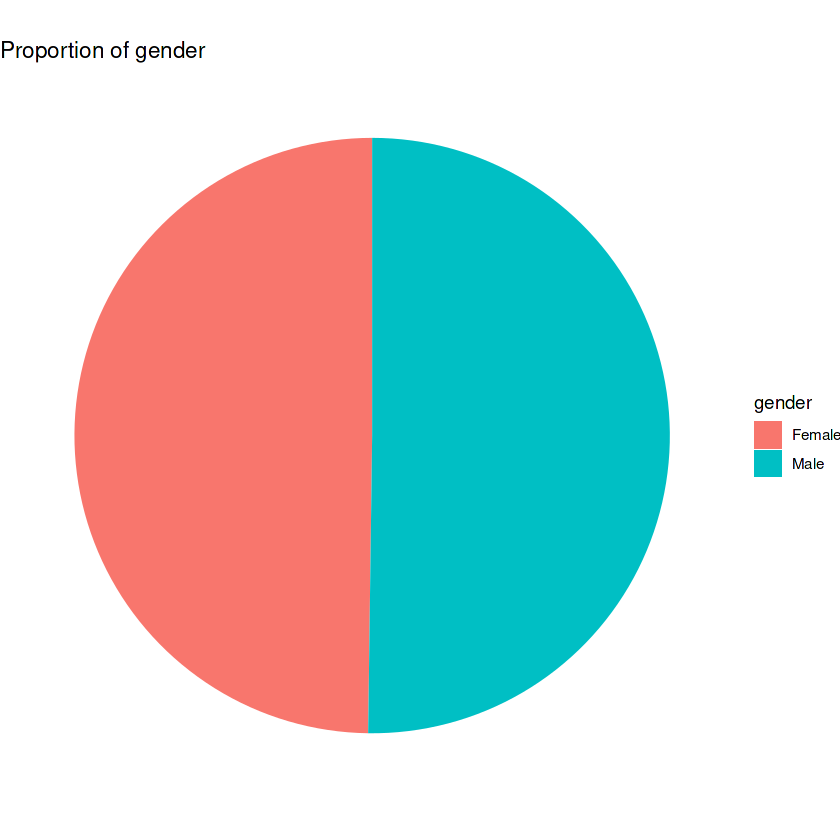

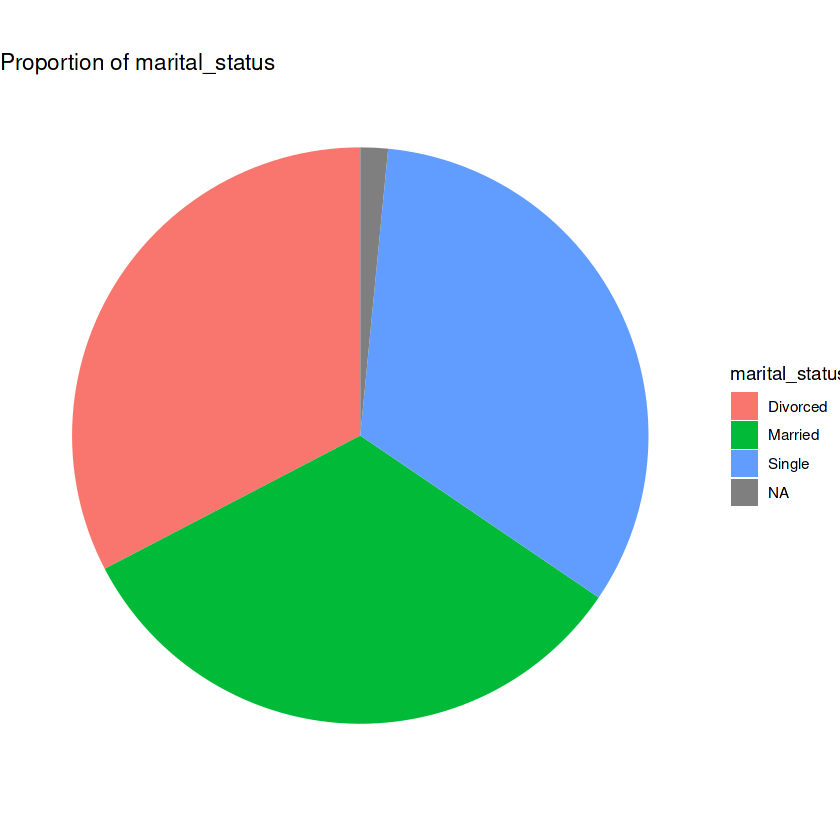

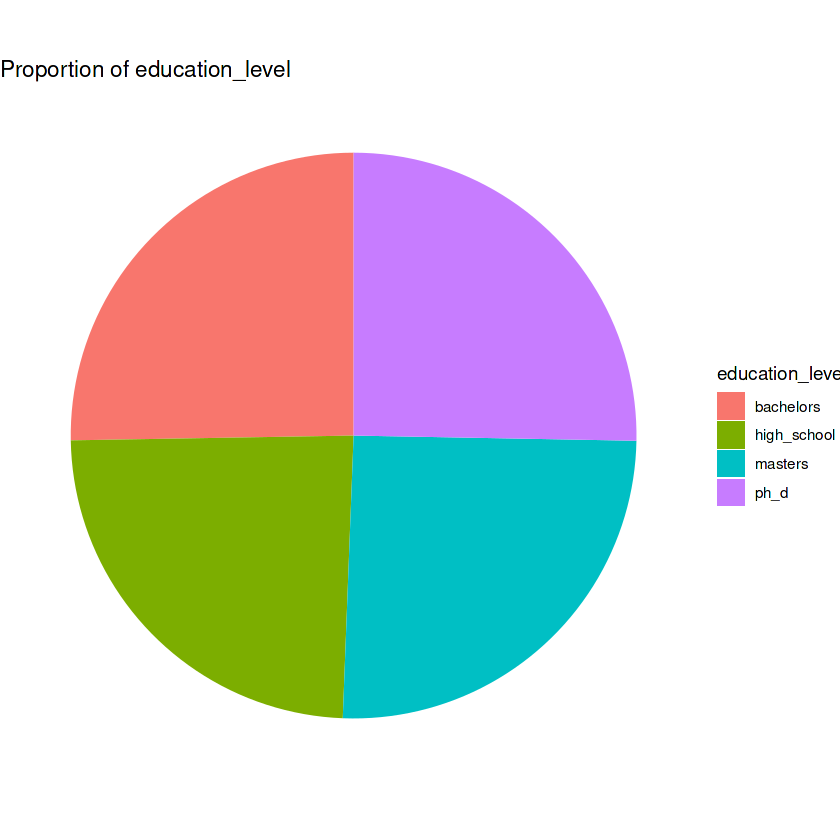

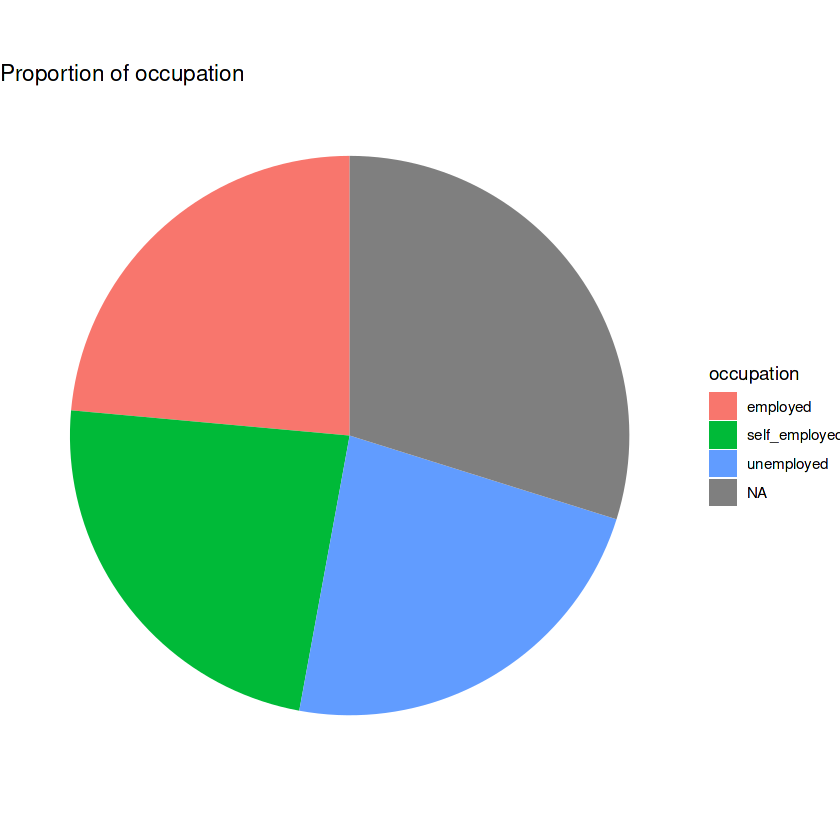

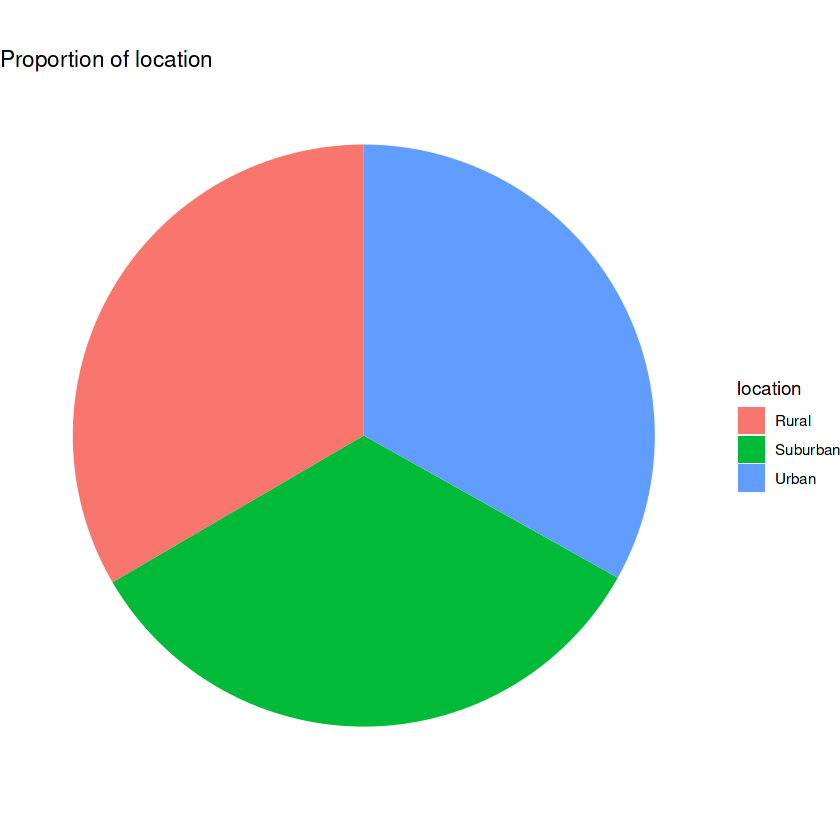

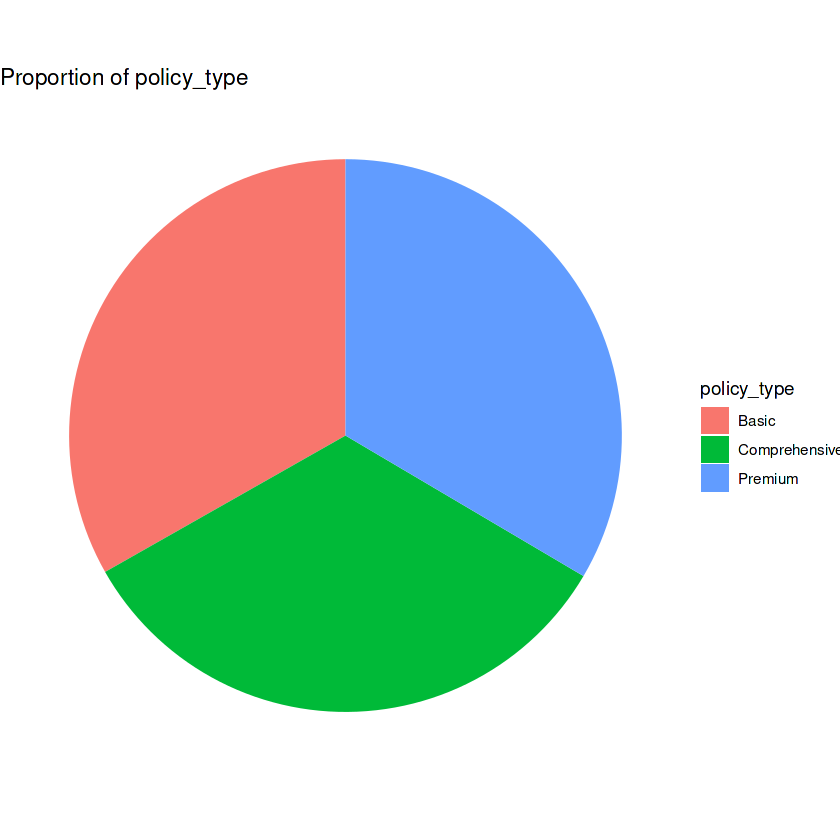

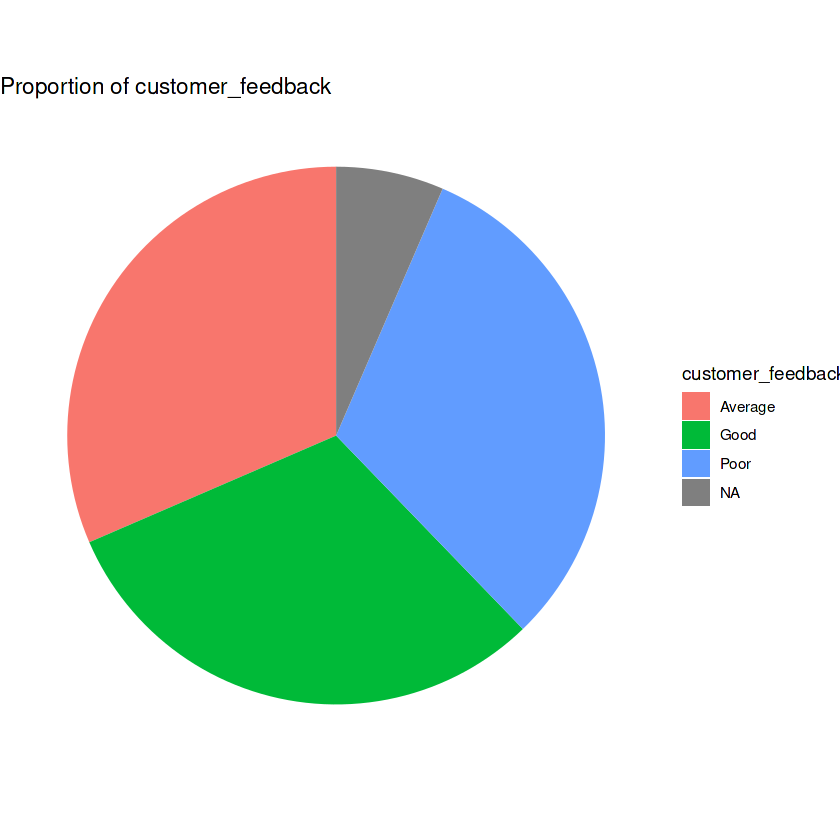

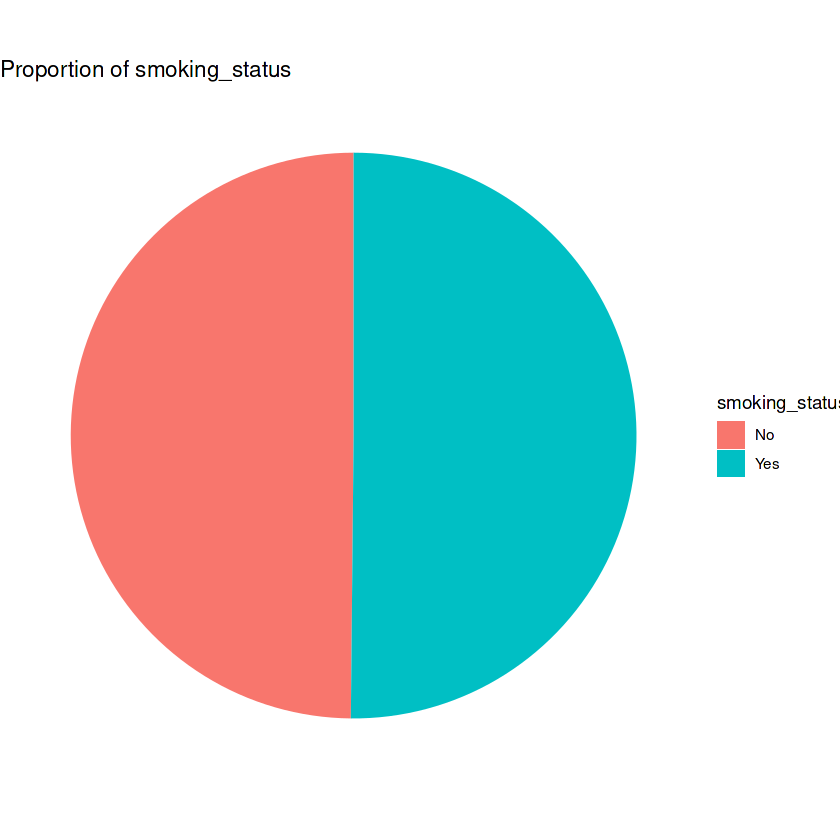

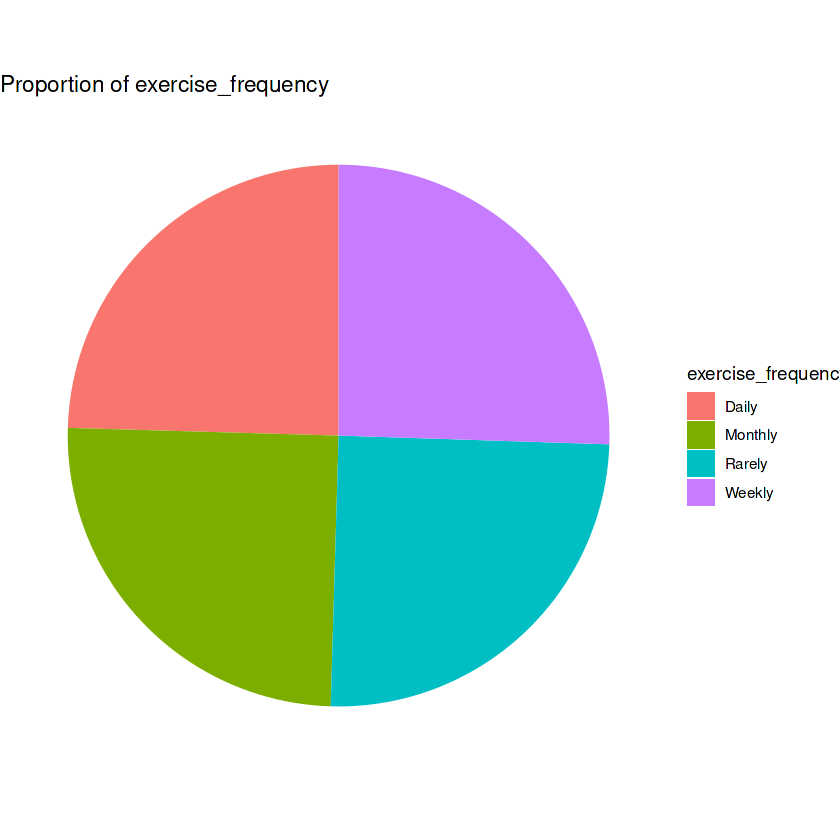

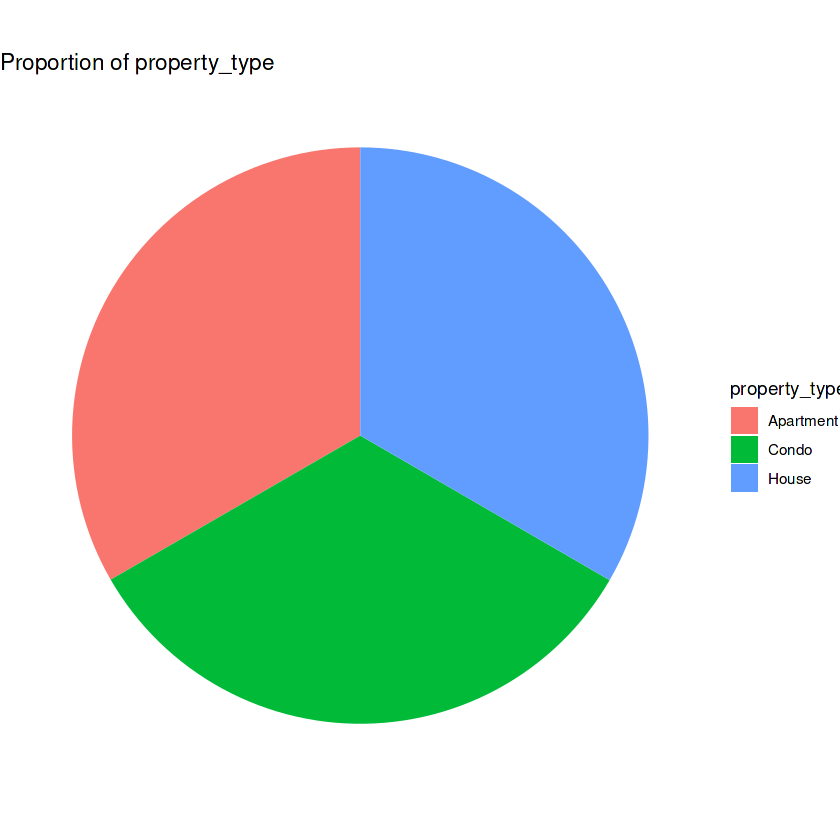

In [7]:
# Function to plot pie charts for proportions
plot_categorical_proportions <- function(df, columns) {
  for (col in columns) {
    p <- df %>%
      count(!!sym(col)) %>%
      ggplot(aes(x = "", y = n, fill = !!sym(col))) +
      geom_bar(stat = "identity", width = 1) +
      coord_polar("y", start = 0) +
      labs(title = paste("Proportion of", col), fill = col) +
      theme_void() +
      theme(legend.position = "right")
    print(p) # print the ggplot object
  }
}

# Plot proportions
plot_categorical_proportions(train, categorical_cols)

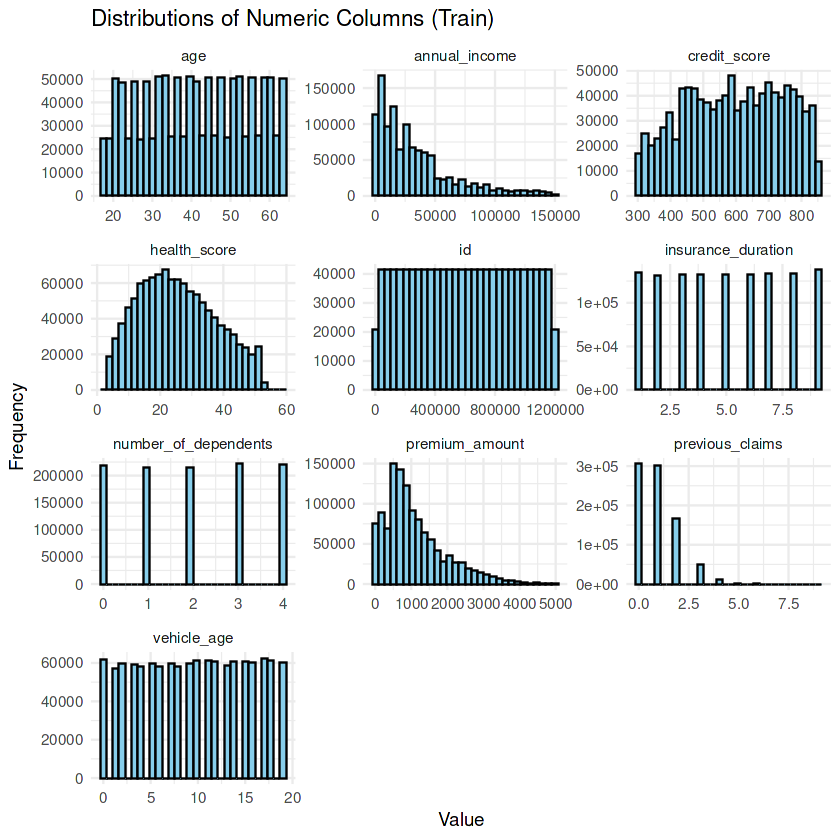

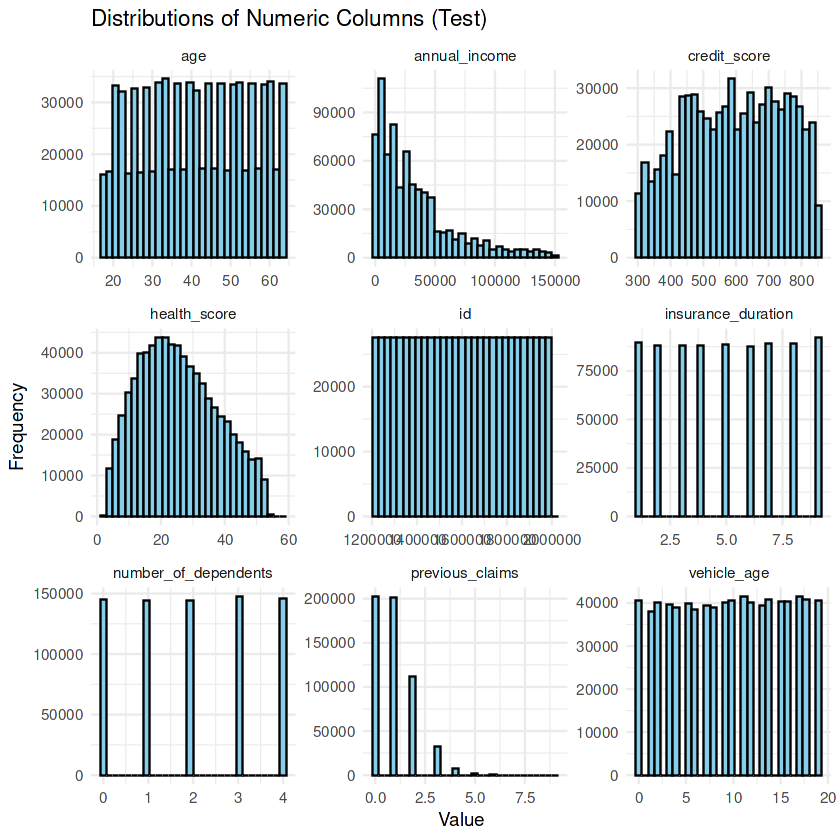

In [8]:
# Function to create histogram plot
plot_numeric_distributions <- function(data, title) {
  numeric_cols <- data %>% select(where(is.numeric))
  numeric_long <- numeric_cols %>%
    pivot_longer(cols = everything(), names_to = "variable", values_to = "value")
  
  # Remove non-finite values
  numeric_long <- numeric_long %>% filter(is.finite(value))
  
  # Convert to long format for ggplot
  ggplot(numeric_long, aes(x = value)) +
    geom_histogram(bins = 30, fill = "skyblue", color = "black") +
    facet_wrap(~variable, scales = "free", ncol = 3) +
    labs(title = title, x = "Value", y = "Frequency") +
    theme_minimal() +
    scale_x_continuous(limits = function(x) c(min(x), max(x)))
}

# Call the function for both datasets
plot_numeric_distributions(train, "Distributions of Numeric Columns (Train)")
plot_numeric_distributions(test, "Distributions of Numeric Columns (Test)")


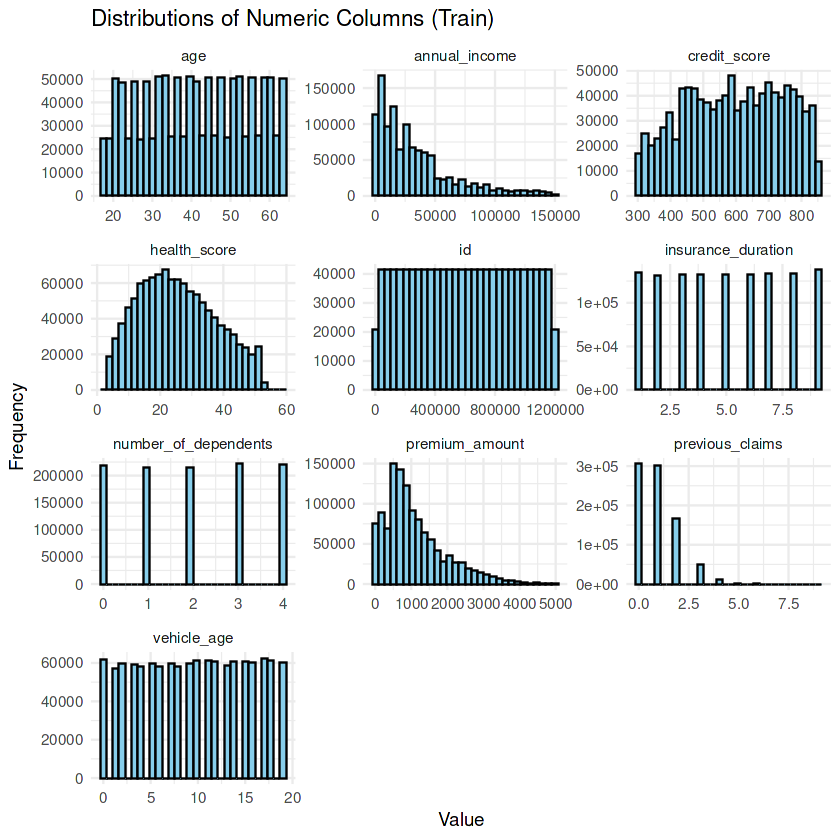

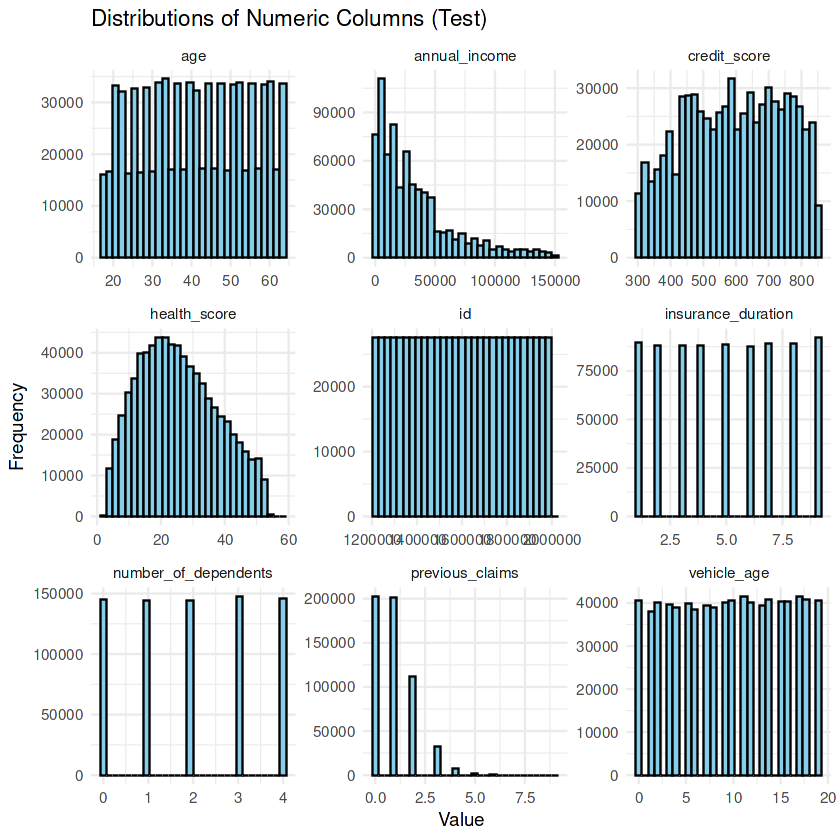

In [9]:
# Function to create histogram plot

plot_numeric_distributions <- function(data, title) {
  numeric_cols <- data %>% select(where(is.numeric))
  numeric_long <- numeric_cols %>%
    pivot_longer(cols = everything(), names_to = "variable", values_to = "value")

  # Remove non-finite values
  numeric_long <- numeric_long %>% filter(is.finite(value))
    
  # Convert to long format for ggplot
  ggplot(numeric_long, aes(x = value)) +
    geom_histogram(bins = 30, fill = "skyblue", color = "black") +
    facet_wrap(~variable, scales = "free", ncol = 3) +
    labs(title = title, x = "Value", y = "Frequency") +
    theme_minimal()
}

# Call the function for both datasets
plot_numeric_distributions(train, "Distributions of Numeric Columns (Train)")
plot_numeric_distributions(test, "Distributions of Numeric Columns (Test)")

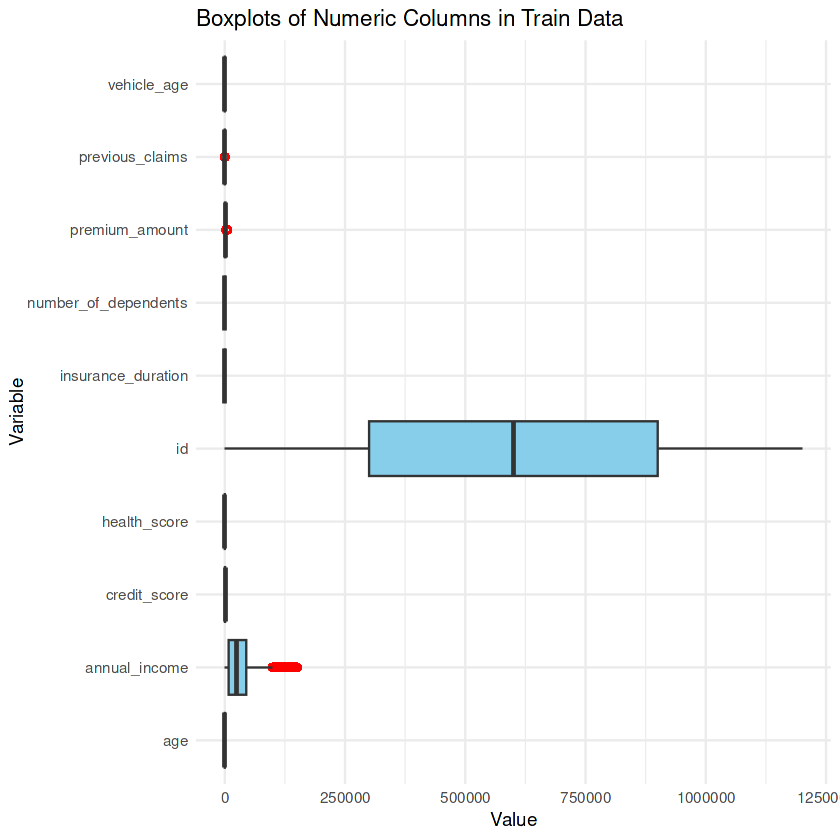

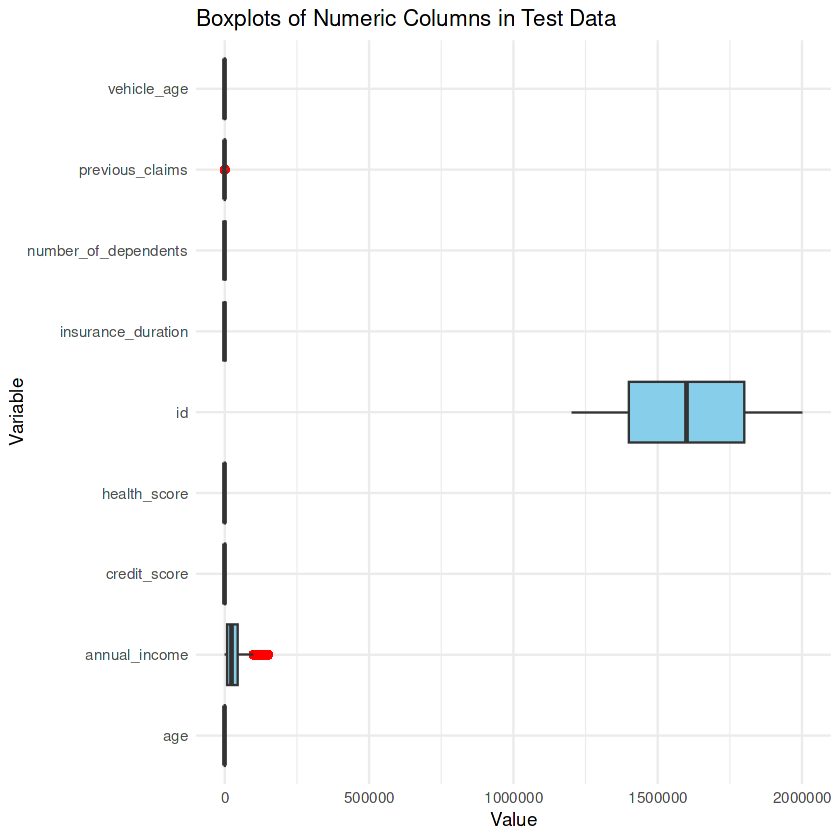

In [10]:
# Function to create boxplots for numeric columns
plot_numeric_boxplots <- function(data, title) {
  # Select only numeric columns
  numeric_cols <- data %>% select(where(is.numeric))
  
  # Convert to long format for ggplot
  numeric_long <- numeric_cols %>%
    pivot_longer(cols = everything(), names_to = "variable", values_to = "value")

  # Remove non-finite values
  numeric_long <- numeric_long %>% filter(is.finite(value))
    
  # Create the boxplot
  ggplot(numeric_long, aes(x = variable, y = value)) +
    geom_boxplot(fill = "skyblue", outlier.color = "red", outlier.shape = 1) +
    coord_flip() +
    labs(title = title,
         x = "Variable", y = "Value") +
    theme_minimal()
}

# Plot for train dataframe
plot_numeric_boxplots(train, "Boxplots of Numeric Columns in Train Data")

# Plot for test dataframe
plot_numeric_boxplots(test, "Boxplots of Numeric Columns in Test Data")


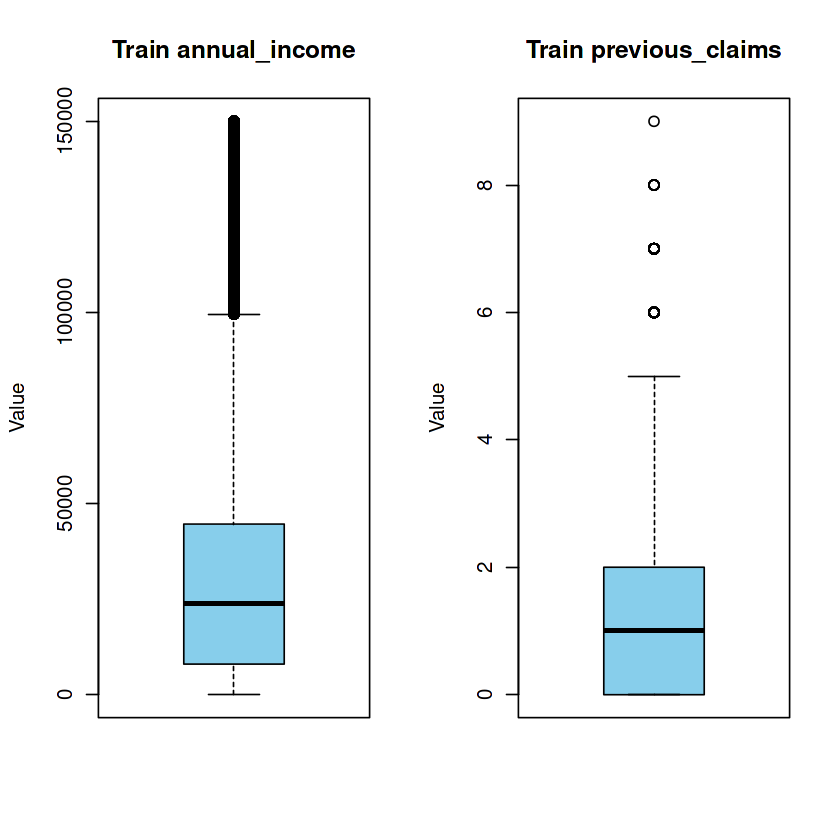

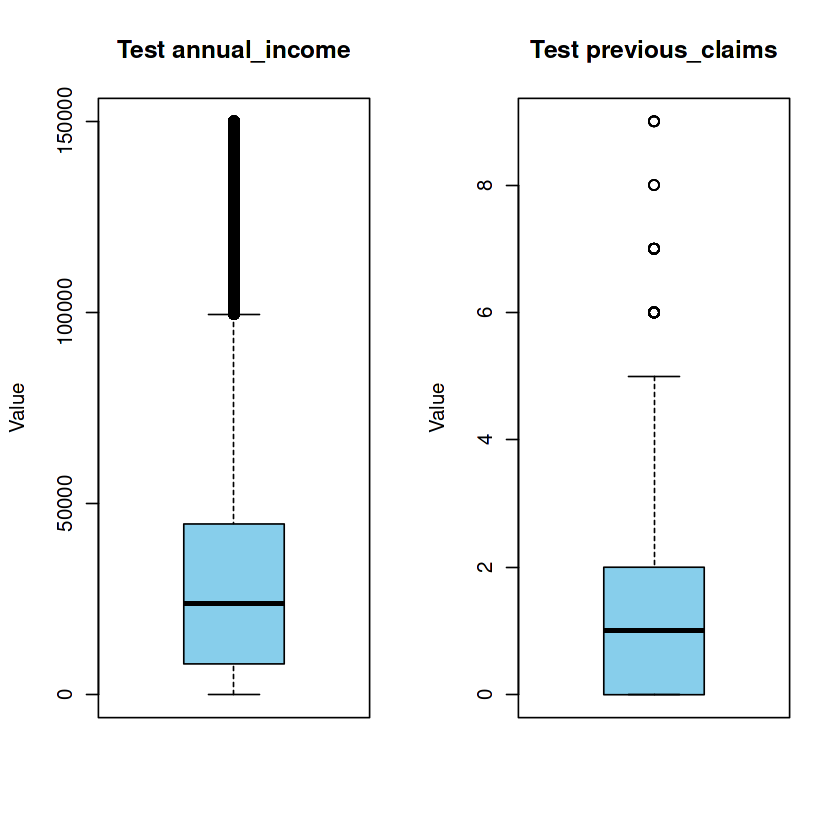

In [11]:
# Create boxplots for specified variables
create_boxplots <- function(data, variables, dataset_name) {
  par(mfrow = c(1, length(variables))) # Adjust layout based on number of variables
  for (var in variables) {
    boxplot(data[[var]], 
            main = paste(dataset_name, var), 
            ylab = "Value", 
            col = "skyblue",
            outline = TRUE) # Highlight outliers
  }
  par(mfrow = c(1,1)) # Reset layout to default
}

# Variables to plot
variables_to_plot <- c("annual_income", "previous_claims")

# Call the function for train and test datasets
create_boxplots(train, variables_to_plot, "Train")
create_boxplots(test, variables_to_plot, "Test")

# Transform Features

## Impute NA values

In [12]:
# Impute numerical columns with mean
for (col in numerical_cols) {
  mean_value <- mean(train[[col]], na.rm = TRUE)
  train[[col]][is.na(train[[col]])] <- mean_value
  test[[col]][is.na(test[[col]])] <- mean_value
}

# Replace missing values in categorical columns with unknown 
for (col in categorical_cols) {
  train[[col]][is.na(train[[col]])] <- "unknown"
  test[[col]][is.na(test[[col]])] <- "unknown"
}

# Impute datetime column with the median date
median_date <- median(as.POSIXct(train$policy_start_date, format = "%Y-%m-%d %H:%M:%S"), na.rm = TRUE)
train$policy_start_date[is.na(train$policy_start_date)] <- as.character(median_date)
test$policy_start_date[is.na(test$policy_start_date)] <- as.character(median_date)

# Verify no missing values remain
colSums(is.na(train))
colSums(is.na(test))

id                  age               gender 
                   0                    0                    0 
       annual_income       marital_status number_of_dependents 
                   0                    0                    0 
     education_level           occupation         health_score 
                   0                    0                    0 
            location          policy_type      previous_claims 
                   0                    0                    0 
         vehicle_age         credit_score   insurance_duration 
                   0                    0                    0 
   policy_start_date    customer_feedback       smoking_status 
                   0                    0                    0 
  exercise_frequency        property_type       premium_amount 
                   0                    0                    0

id                  age               gender 
                   0                    0                    0 
       annual_income       marital_status number_of_dependents 
                   0                    0                    0 
     education_level           occupation         health_score 
                   0                    0                    0 
            location          policy_type      previous_claims 
                   0                    0                    0 
         vehicle_age         credit_score   insurance_duration 
                   0                    0                    0 
   policy_start_date    customer_feedback       smoking_status 
                   0                    0                    0 
  exercise_frequency        property_type 
                   0                    0

## Feature Scaling

In [13]:
# Normalize continuous features to improve model convergence 

min_max_normalize <- function(x) {
  (x - min(x)) / (max(x) - min(x))
}

# Normalize features in train dataset
train$annual_income_normalized <- min_max_normalize(train$annual_income)
train$credit_score_normalized <- min_max_normalize(train$credit_score)
train$health_score_normalized <- min_max_normalize(train$health_score)

# Normalize features in test dataset
# Important: Use min and max values from train dataset for test dataset
test$annual_income_normalized <- (test$annual_income - min(train$annual_income)) / 
  (max(train$annual_income) - min(train$annual_income))
test$credit_score_normalized <- (test$credit_score - min(train$credit_score)) / 
  (max(train$credit_score) - min(train$credit_score))
test$health_score_normalized <- (test$health_score - min(train$health_score)) / 
  (max(train$health_score) - min(train$health_score))


## Handle Outliers

In [14]:
# Function to cap outliers
cap_outliers <- function(data, column, lower_bound, upper_bound) {
  data[[column]] <- pmin(pmax(data[[column]], lower_bound), upper_bound)
  return(data)
}

# Calculate bounds for previous_claims using IQR method
bounds_previous_claims <- quantile(train$previous_claims, probs = c(0.25, 0.75))
iqr_previous_claims <- bounds_previous_claims[2] - bounds_previous_claims[1]
bounds_previous_claims <- c(bounds_previous_claims[1] - 1.5 * iqr_previous_claims,
                             bounds_previous_claims[2] + 1.5 * iqr_previous_claims)

# Calculate bounds for annual_income 
bounds_annual_income <- quantile(train$annual_income, probs = c(0.25, 0.75))
iqr_annual_income <- bounds_annual_income[2] - bounds_annual_income[1]
bounds_annual_income <- c(bounds_annual_income[1] - 1.5 * iqr_annual_income,
                           bounds_annual_income[2] + 1.5 * iqr_annual_income)

# Handle outliers in train dataset
train <- cap_outliers(train, "previous_claims", bounds_previous_claims[1], bounds_previous_claims[2])
train <- cap_outliers(train, "annual_income", bounds_annual_income[1], bounds_annual_income[2])

# Handle outliers in test dataset
test <- cap_outliers(test, "previous_claims", bounds_previous_claims[1], bounds_previous_claims[2])
test <- cap_outliers(test, "annual_income", bounds_annual_income[1], bounds_annual_income[2])

# Modeling

In [15]:
# Set seed for reproducibility
set.seed(123)

# Splitting the data into train (80%) and validation (20%)
train_index <- createDataPartition(train$premium_amount, p = 0.8, list = FALSE)
train_set <- train[train_index, ]
valid_set <- train[-train_index, ]

# Log transform the target variable
train_label <- log1p(train_set$premium_amount)
valid_label <- log1p(valid_set$premium_amount)

# Dynamically exclude unnecessary columns
exclude_cols <- c("id", "policy_start_date", "premium_amount")
train_set <- train_set %>% select(-all_of(exclude_cols))
valid_set <- valid_set %>% select(-all_of(exclude_cols))

# Convert categorical variables to numeric encoding
convert_categorical_to_numeric <- function(df1, df2) {
  for (col in names(df1)) {
    if (is.character(df1[[col]]) || is.factor(df1[[col]])) {
      levels <- unique(c(df1[[col]], df2[[col]]))  # Ensure consistency
      df1[[col]] <- as.numeric(factor(df1[[col]], levels = levels))
      df2[[col]] <- as.numeric(factor(df2[[col]], levels = levels))
    }
  }
  return(list(df1 = df1, df2 = df2))
}

train_valid <- convert_categorical_to_numeric(train_set, valid_set)
train_set <- train_valid$df1
valid_set <- train_valid$df2

# Convert data to matrices
train_matrix <- as.matrix(train_set)
valid_matrix <- as.matrix(valid_set)

# Check for NA values
if (any(is.na(train_matrix)) || any(is.na(valid_matrix))) {
  stop("NA values found in matrices.")
}

# Create LightGBM datasets
lgb_train <- lgb.Dataset(data = train_matrix, label = train_label)
lgb_valid <- lgb.Dataset(data = valid_matrix, label = valid_label)

# Train the LightGBM model with validation
params <- list(
  objective = "regression",
  metric = "rmse",
  boosting_type = "gbdt",
  learning_rate = 0.05,  
  num_leaves = 31,
  max_depth = -1,
  min_data_in_leaf = 20  # Prevent overfitting
)

lgb_model <- lgb.train(
  params = params,
  data = lgb_train,
  valids = list(validation = lgb_valid),
  nrounds = 1000,
  early_stopping_rounds = 20,
  verbose = 1
)

# Predict on validation set
pred_lgb <- predict(lgb_model, valid_matrix)
pred_lgb <- expm1(pmax(0, pred_lgb))  # Reverse log transformation and clip negative predictions

# Calculate RMSLE
rmsle <- sqrt(mean((log1p(pred_lgb) - log1p(expm1(valid_label)))^2))
cat("RMSLE:", round(rmsle, 4), "\n")


[1]:	validation's rmse:1.09103 
[2]:	validation's rmse:1.08728 
[3]:	validation's rmse:1.08389 
[4]:	validation's rmse:1.0808 
[5]:	validation's rmse:1.07803 
[6]:	validation's rmse:1.0755 
[7]:	validation's rmse:1.0732 
[8]:	validation's rmse:1.07114 
[9]:	validation's rmse:1.06928 
[10]:	validation's rmse:1.06758 
[11]:	validation's rmse:1.06603 
[12]:	validation's rmse:1.06463 
[13]:	validation's rmse:1.06338 
[14]:	validation's rmse:1.06223 
[15]:	validation's rmse:1.0612 
[16]:	validation's rmse:1.06023 
[17]:	validation's rmse:1.05937 
[18]:	validation's rmse:1.05859 
[19]:	validation's rmse:1.05785 
[20]:	validation's rmse:1.05721 
[21]:	validation's rmse:1.05666 
[22]:	validation's rmse:1.05609 
[23]:	validation's rmse:1.05563 
[24]:	validation's rmse:1.05521 
[25]:	validation's rmse:1.05478 
[26]:	validation's rmse:1.05438 
[27]:	validation's rmse:1.05406 
[28]:	validation's rmse:1.05375 
[29]:	validation's rmse:1.05348 
[30]:	validation's rmse:1.05321 
[31]:	validation's rmse

RMSLE: 1.0491 


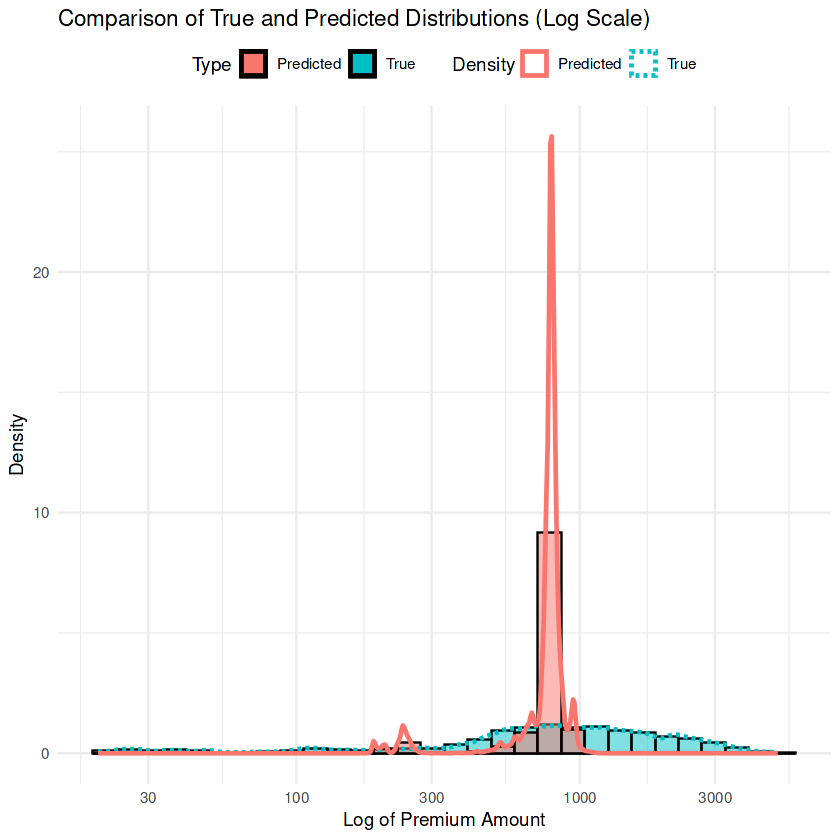

In [16]:
# Compare True vs. Predicted distributions
valid_actual <- expm1(valid_label)  # Reverse log transformation
valid_predictions <- pred_lgb

# Create a combined dataframe for visualization
comparison_df <- data.frame(
  Value = c(valid_actual, valid_predictions),
  Type = rep(c("True", "Predicted"), each = length(valid_actual))
)

ggplot() +
  geom_histogram(aes(x = valid_actual, y = after_stat(density), fill = "True"), 
                 bins = 30, alpha = 0.5, color = "black") +
  geom_histogram(aes(x = valid_predictions, y = after_stat(density), fill = "Predicted"), 
                 bins = 30, alpha = 0.5, color = "black") +
  geom_density(aes(x = valid_actual, color = "True"), linewidth = 1, linetype = "dashed") +
  geom_density(aes(x = valid_predictions, color = "Predicted"), linewidth = 1) +
  scale_x_log10() +  # Logarithmic scale for better visualization
  labs(
    title = "Comparison of True and Predicted Distributions (Log Scale)",
    x = "Log of Premium Amount",
    y = "Density",
    fill = "Type",
    color = "Density"
  ) +
  theme_minimal() +
  theme(legend.position = "top")

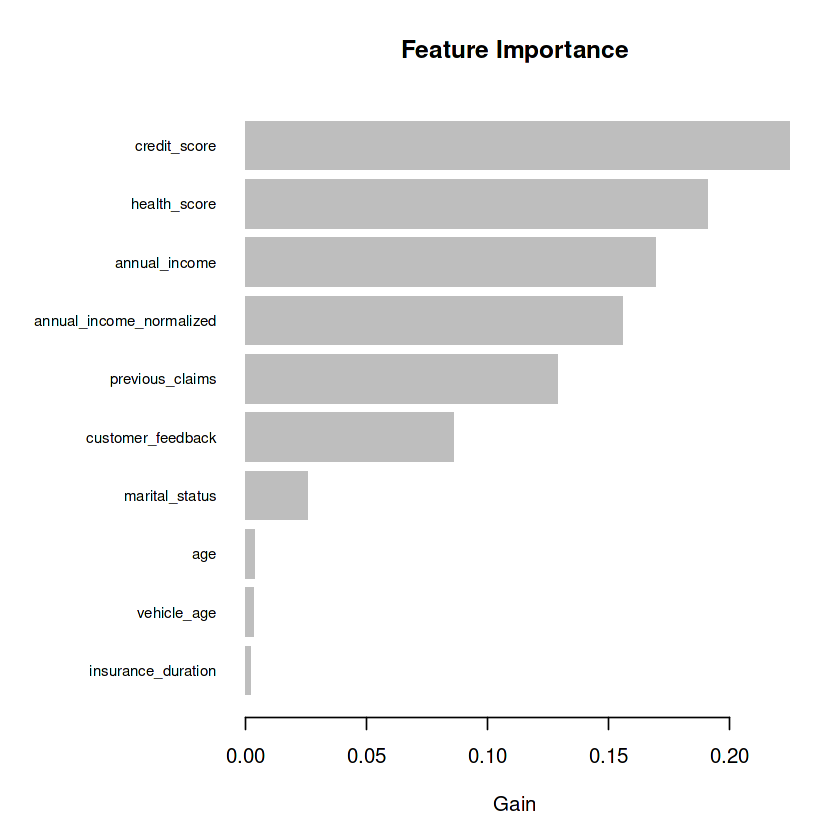

In [17]:
# Display Feature Importance
lgb.importance(lgb_model) %>%
  lgb.plot.importance()

# Predict on test set and submission

In [18]:
# Predict on the test dataset (unseen data)
final_test_matrix <- as.matrix(test %>% select(-all_of(c("id", "policy_start_date"))))
final_test_predictions <- expm1(pmax(0, predict(lgb_model, final_test_matrix)))

# Create submission file
submission <- test %>%
  select(id) %>%
  mutate(`Premium Amount` = final_test_predictions)

write.csv(submission, "submission.csv", row.names = FALSE)
cat("Submission file saved as 'submission.csv'.\n")

Submission file saved as 'submission.csv'.


In [19]:
# Display the first few rows of test with predictions
head(submission)

id,Premium Amount
<dbl>,<dbl>
1200000,738.9132
1200001,738.9132
1200002,738.9132
1200003,738.9132
1200004,738.9132
1200005,738.9132
